In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import Holt, ExponentialSmoothing

Reading in our store data.

In [3]:
df = pd.read_csv('stores.csv', index_col=0)
df.head()

,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,
2013-01-01,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,January,Tuesday,10.92
2013-01-01,26,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,January,Tuesday,218.40
2013-01-01,27,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,January,Tuesday,125.55
2013-01-01,54,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,January,Tuesday,453.60
2013-01-01,35,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,January,Tuesday,294.00


In [4]:
df.index = pd.to_datetime(df.index)

**We have to split our data before we model**

In [5]:
train = df.loc[:'2015']
validate = df.loc['2016']
test = df.loc['2017']

train.shape, validate.shape, test.shape

((547500, 11), (183000, 11), (182500, 11))

**we need to perform an aggreagtion to have one point of data per dat. We can resample by th day and take the sm of the sales_total column.**

In [6]:
day_train = train.resample('d').sales_total.sum()
day_val = validate.resample('d').sales_total.sum()
day_test = test.resample('d').sales_total.sum()

day_train.head()

sale_date
2013-01-01    73844.01
2013-01-02    73570.58
2013-01-03    78169.48
2013-01-04    84467.73
2013-01-05    87621.85
Freq: D, Name: sales_total, dtype: float64

**We can visualize train, test, split**

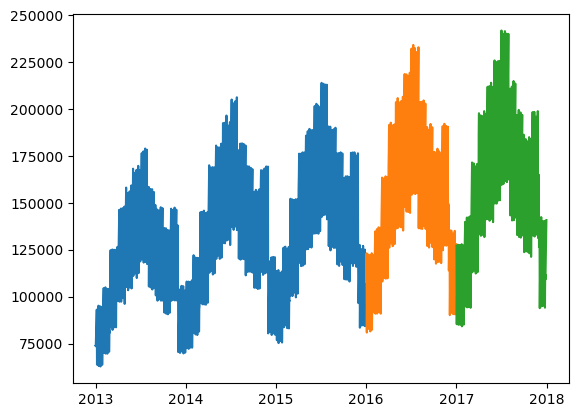

In [7]:
plt.plot(day_train)
plt.plot(day_val)
plt.plot(day_test)
plt.show()

Now that our data is properly split, let's try two different modeling approaches:
- One baseline model (rolling average)
- One non-baseline model (Holt's seasonal trend)

In [8]:
month_rolling = round(day_train.rolling(30).mean()[-1], 2)
month_rolling

105739.12

We can also create a rolling average of the last 180 days in our dataset. This may perform better (or worse) than out monthly rolling average.

In [9]:
hy_rolling = round(day_train.rolling(180).mean()[-1], 2)

In [10]:
preds = pd.DataFrame({'actual': day_val,
                      'hy_rolling': hy_rolling,
                     'month_rolling': month_rolling})

preds.head()

,actual,hy_rolling,month_rolling
sale_date,,,
2016-01-01,107875.26,145666.45,105739.12
2016-01-02,114330.43,145666.45,105739.12
2016-01-03,123144.91,145666.45,105739.12
2016-01-04,80873.97,145666.45,105739.12
2016-01-05,95429.90,145666.45,105739.12


In [11]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [12]:
eval_preds(preds, 'hy_rolling')

34405.71

In [13]:
eval_preds(preds, 'month_rolling')

57384.82

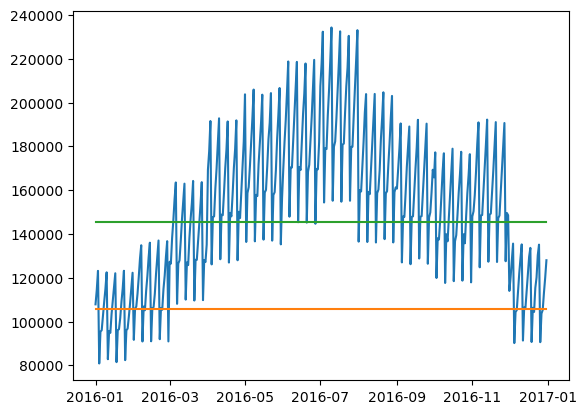

In [14]:
plt.plot(preds['actual'])
plt.plot(preds['month_rolling'])
plt.plot(preds['hy_rolling'])
plt.show()

**Things i passed into my model:**

- My train dataset
- The number of observations before the seasonality repeats (365)
- The type of trend in my dataset (it's additive)
- Seasinality is also set to additive

**Finally, hiding at the end i am calling the .fit mehtod on my model.**

In [15]:
hst_model = ExponentialSmoothing(day_train, seasonal_periods=365, trend='add', seasonal='add').fit()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


While I am calling the .forecast() method on my model object, I speicfy how many observations to produce, in this case, I am asking for a number of observations equal to the days  value

In [16]:
hst_model.forecast(day_val.shape[0])

2016-01-01    100114.134028
2016-01-02    108505.451715
2016-01-03    112492.190484
2016-01-04    120205.367567
2016-01-05    104386.511068
                  ...      
2016-12-27    133416.358399
2016-12-28    115047.490633
2016-12-29    105504.232098
2016-12-30    110782.483640
2016-12-31    111645.544104
Freq: D, Length: 366, dtype: float64

I will add this predicitions to my predictions data frame so i can evaluate them.

In [17]:
preds['hst'] = hst_model.forecast(day_val.shape[0])

In [18]:
eval_preds(preds, 'hst')


25942.97

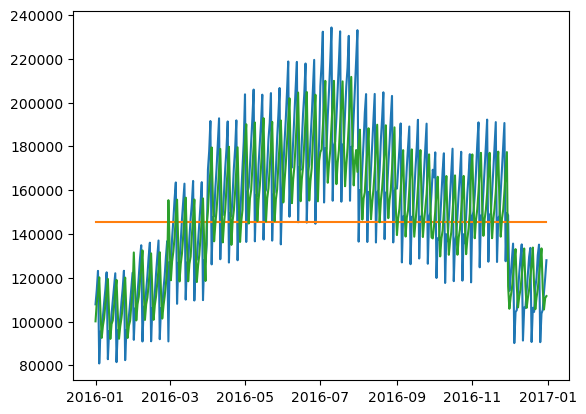

In [19]:
plt.plot(preds['actual'])
plt.plot(preds['hy_rolling'])
plt.plot(preds['hst'])
plt.show()